In [ ]:
pip install git+https://github.com/rwalk/gsdmm.git

In [ ]:
!pip install pyLDAvis

In [ ]:
from gsdmm import MovieGroupProcess

In [ ]:
import numpy as np 
import pandas as pd
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
from gensim.utils import simple_preprocess
import gensim, spacy
from gensim.models.ldamulticore import LdaMulticore
import re


from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [ ]:
#Load the dataset
poems_df = pd.read_excel('/content/drive/MyDrive/match_alldata.xlsx')

In [ ]:
#set the index as poem number
poems_df.set_index('new_code', inplace=True)
poems_df.head(2)

,Code,Code_lower,Count_lower,Title,Title_lower,Year_of_workshop,quarter,Org,Country,Big_Idea,age,gender,Repeat,Notes,Content,Content1,Content2,RIGHT
new_code,,,,,,,,,,,,,,,,,,
1,4161,4161,2,Love. Peace Lily,love. peace lily,2021,NaN,WINGS,Singapore,Taking Risks,NaN,F,1,older woman,how are you doing this morning \nmy love? \nwo...,how are you doing this morning \nmy love? \nwo...,how are you doing this morning \nmy love? \nwo...,1
2,4161,4161,2,Relating Power,relating power,2017,1,VSA,Singapore,Power,0.0,M,1,young adult in Singapore with developmental or...,eight fish \nrelating power \nglad \nmobility ...,eight fish \nrelating power \nglad \nmobility ...,eight fish \nrelating power \nglad \nmobility ...,1


In [ ]:
#function to remove the line delimiter on content column
def singleRow(x):
  return re.sub('\n','', x)

In [ ]:
poems_df['Content'] = poems_df['Content'].apply(lambda x: singleRow(x))

In [ ]:
poems_df['length'] = poems_df.Content.apply(lambda row: len(row.split()))
print('Mean length: ', poems_df['length'].mean())

Mean length:  74.78674596431605


In [ ]:
#Extract the script of a single poem
script = poems_df.loc[[2]]['Content'].values[0]
script

'eight fish relating power glad mobility knowledge gives some power different power surfer swim in the ocean i was glad i am relaxing when i am sitting on the chair ocean has power to splash ko has power to carry heavy things mother has power to mop the floor and make the chocolate mud cake father has power to do exercise brother has power to do meridian junior college work person has power to walk ko has power to carry light things mother has power to pick the leaves father has power to run in marina way playground brother has the power to read newspaper.'

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


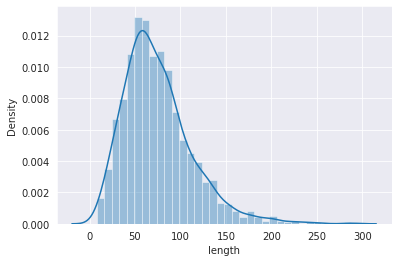

In [ ]:
import seaborn as sns
sns.set_style(style="darkgrid")

sns.distplot(poems_df['length'])

**GSDMM**

Short text clustering is a challenging problem due to its sparse, high-dimensional, and large-volume characteristics. The GSDMM has the following nice properties:

GSDMM can infer the number of clusters automatically;
GSDMM has a clear way to balance the completeness and homogeneity of the clustering results;
GSDMM is fast to converge;
Unlike the Vector Space Model (VSM)-based approaches, GSDMM can cope with the sparse and highdimensional problem of short texts;
Like Topic Models (e.g., PLSA and LDA), GSDMM can also obtain the representative words of each cluster.
Let`s take a closer look at the last point (about comparing it with the most popular topic models):

In LDA, documents are considered to be a mixture of topics. Short text only deals with one topic (most of the time) so this assumption is not reliable anymore;
Shorter text means fewer data to rely on during the LDA inference steps.
Well, the Gibbs Sampling Dirichlet Mixture Model (GSDMM) is an “extended” LDA algorithm, that makes the initial assumption: 1 topic is 1 document.

The words within a document are generated using the same unique topic, and not from a mixture of topics as it was in the original LDA.

GSDMM is a good choice for short text topic modeling.

# Data Preprocessing


*   removing symbols with regular expressions;
*   tokenization and delete punctuation;
*   create N-grams: bigrams and trigrams;
*   lemmatization;
*   removing stop-words.
*   List item



In [ ]:
poems_df['Content_list'] = poems_df.Content.values.tolist()

In [ ]:
# remove characters
poems_df['Content_list'] = [re.sub('\s+', ' ', sent) for sent in poems_df['Content_list']]
poems_df['Content_list'] = [re.sub("\'", "", sent) for sent in poems_df['Content_list']]

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [ ]:
# create N-grams
def make_n_grams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)  # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    bigrams_text = [bigram_mod[doc] for doc in texts]
    trigrams_text =  [trigram_mod[bigram_mod[doc]] for doc in bigrams_text]
    return trigrams_text

In [ ]:
tokens_reviews = list(sent_to_words(poems_df['Content_list']))

In [ ]:
tokens_reviews = make_n_grams(tokens_reviews)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
# I use gensim stop-words and add me own stop-words, based on texts
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in gensim.parsing.preprocessing.STOPWORDS.union(set(['also', 'meanwhile','however', 
                                                                                                                           'hour', 'soon',
                                                                                                                           'there', 'leave',
                                                                                                                           'arrive', 
                                                                                                                          'service', 'come', 
                                                                                                                          'ask', 'lot', 'thing', 
                                                                                                                          'so', 'add', 'rarely',
                                                                                                                          'use', 'look', 'so',
                                                                                                                          'bring', 'need', 'very',
                                                                                                                          'think', 'value', 'include']))] for doc in texts]

In [ ]:
def lemmatization(texts, allowed_postags= ['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
! python -m spacy download en_core_web_sm

2022-07-27 15:02:10.802125: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 477 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# do lemmatization keeping only noun, vb, adv
# because adj is not informative for reviews topic modeling
reviews_lemmatized = lemmatization(tokens_reviews, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
# remove stop words after lemmatization
reviews_lemmatized = remove_stopwords(reviews_lemmatized)

# GSDM Model and Visualisation

In [ ]:
np.random.seed(0)

In [ ]:
mgp = MovieGroupProcess(K=6, alpha=0.01, beta=0.01, n_iters=100)

vocab = set(x for review in reviews_lemmatized for x in review)
n_terms = len(vocab)
model = mgp.fit(reviews_lemmatized, n_terms)

In stage 0: transferred 852 clusters with 6 clusters populated
In stage 1: transferred 424 clusters with 6 clusters populated
In stage 2: transferred 229 clusters with 6 clusters populated
In stage 3: transferred 121 clusters with 6 clusters populated
In stage 4: transferred 84 clusters with 6 clusters populated
In stage 5: transferred 74 clusters with 6 clusters populated
In stage 6: transferred 65 clusters with 6 clusters populated
In stage 7: transferred 64 clusters with 6 clusters populated
In stage 8: transferred 63 clusters with 6 clusters populated
In stage 9: transferred 62 clusters with 6 clusters populated
In stage 10: transferred 48 clusters with 6 clusters populated
In stage 11: transferred 37 clusters with 6 clusters populated
In stage 12: transferred 47 clusters with 6 clusters populated
In stage 13: transferred 55 clusters with 6 clusters populated
In stage 14: transferred 47 clusters with 6 clusters populated
In stage 15: transferred 50 clusters with 6 clusters populate

In [ ]:
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster,sort_dicts))

In [ ]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-10:][::-1]
print('\nMost important clusters (by number of docs inside):', top_index)
# show the top 5 words in term frequency for each cluster 
top_words(mgp.cluster_word_distribution, top_index, 10)

Number of documents per topic : [213 234  27 577  58  68]

Most important clusters (by number of docs inside): [3 1 0 5 4 2]

Cluster 3 : [('time', 884), ('life', 536), ('good', 382), ('people', 345), ('change', 304), ('happy', 246), ('want', 223), ('feel', 173), ('love', 156), ('try', 155)]

Cluster 1 : [('family', 263), ('want', 246), ('study', 240), ('happy', 229), ('friend', 206), ('good', 187), ('school', 182), ('love', 146), ('teacher', 129), ('help', 84)]

Cluster 0 : [('beautiful', 154), ('happy', 128), ('flower', 110), ('tree', 107), ('people', 102), ('sky', 97), ('feel', 92), ('want', 84), ('good', 75), ('butterfly', 75)]

Cluster 5 : [('love', 20), ('time', 18), ('feel', 17), ('end', 16), ('way', 15), ('day', 15), ('free', 15), ('know', 14), ('hope', 14), ('safe', 14)]

Cluster 4 : [('people', 62), ('happy', 53), ('country', 47), ('place', 46), ('beautiful', 36), ('temple', 33), ('power', 28), ('good', 28), ('world', 24), ('live', 23)]

Cluster 2 : [('change', 256), ('new', 

In [ ]:
topic_dict = {}
topic_names = ['type 1',
               'type 2',
               'type 3',
               'type 4',
               'type 5',
               'type 6',
              ]
for i, topic_num in enumerate(top_index):
    topic_dict[topic_num]=topic_names[i] 

In [ ]:
def create_topics_dataframe(data_text=poems_df.Content,  mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=reviews_lemmatized):
    result = pd.DataFrame(columns=['Poem', 'Topic', 'Title', 'Lemma-text'])
    for i, text in enumerate(data_text):
        result.at[i, 'Poem'] = text
        result.at[i, 'Title'] = poems_df.Title
        result.at[i, 'Lemma-text'] = lemma_text[i]
        prob = mgp.choose_best_label(reviews_lemmatized[i])
        if prob[1] >= threshold:
            result.at[i, 'Topic'] = topic_dict[prob[0]]
        else:
            result.at[i, 'Topic'] = 'Other'
    return result

In [ ]:
result = create_topics_dataframe(data_text=poems_df.Content, mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=reviews_lemmatized)
result.head(5)

,Poem,Topic,Title,Lemma-text
0,how are you doing this morning my love? would ...,type 2,new_code 1 Love. Peace Lily 2 ...,"[morning, love, like, sunbathe, water, start, ..."
1,eight fish relating power glad mobility knowle...,type 5,new_code 1 Love. Peace Lily 2 ...,"[fish, relate, power, glad, mobility, knowledg..."
2,star wars is a science fiction movie carried b...,type 1,new_code 1 Love. Peace Lily 2 ...,"[star, war, science, fiction, movie, carry, le..."
3,i study in siem reap it's good for me. because...,type 2,new_code 1 Love. Peace Lily 2 ...,"[study, siem_reap, good, teacher, teach, extra..."
4,stripes stripes give zebras power stripes iden...,type 3,new_code 1 Love. Peace Lily 2 ...,"[stripe, stripe, power, stripe, identify, blac..."


In [ ]:
import plotly.express as px

fig = px.pie(result, names='Topic',  title='Topics', color_discrete_sequence=px.colors.sequential.Burg)
fig.show()

# Word Clouds

In [ ]:
result['Lemma_text'] = result['Lemma-text'].apply(lambda row: ' '.join(row))

In [ ]:
result = result.drop('Lemma-text', axis=1)

In [ ]:
from wordcloud import WordCloud 

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def create_WordCloud(data, title=None):
    wordcloud = WordCloud(width = 500, height = 500,
                          background_color ='white',
                          min_font_size = 15
                         ).generate(" ".join(data.values))
                      
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=20)
    plt.show() 

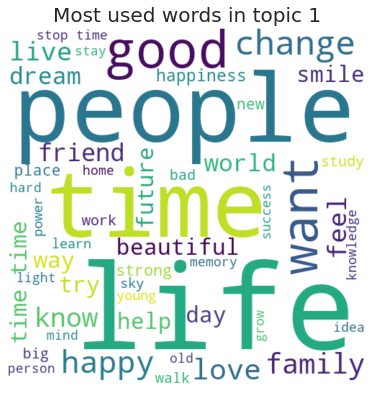

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 1'], title="Most used words in topic 1")

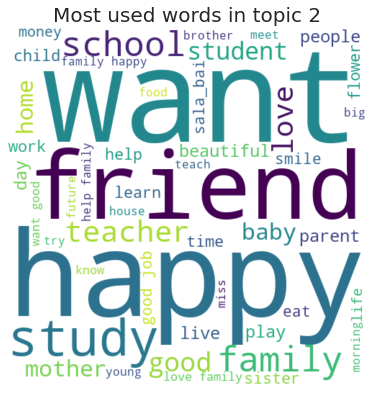

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 2'], title="Most used words in topic 2")

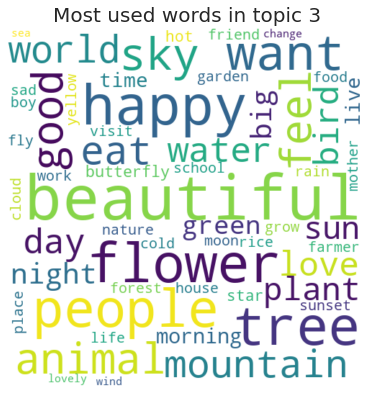

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 3'], title="Most used words in topic 3")

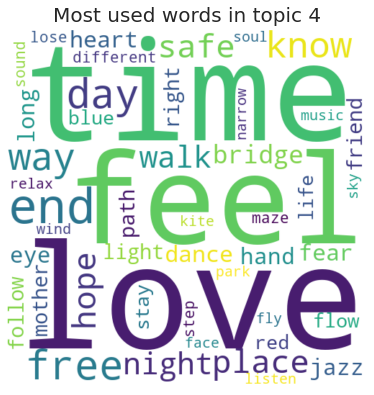

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 4'], title="Most used words in topic 4")

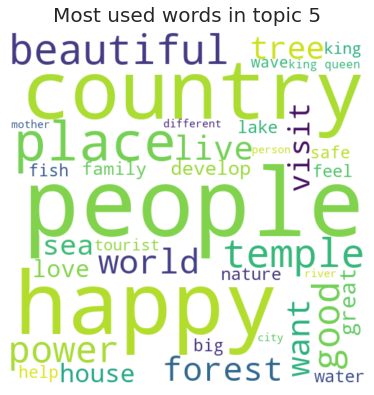

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 5'], title="Most used words in topic 5")

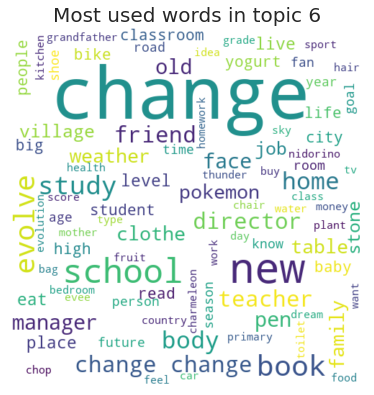

In [ ]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 6'], title="Most used words in topic 6")

# LDA Model and Visualisation 

In [ ]:
id2word = corpora.Dictionary(reviews_lemmatized)
texts = reviews_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
# Use TF-IDF
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [ ]:
from gensim.models.ldamulticore import LdaMulticore

def calc_coherence_values(dictionary, corpus, texts, limit = 12, start = 1, step = 1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,id2word = dictionary, num_topics = num_topics, alpha=.1, eta=0.1, random_state = 42)
        model_list.append(model)
        print('model created')
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
model_list, coherence_values = calc_coherence_values(dictionary = id2word, 
                                                     corpus = corpus_tfidf, 
                                                     texts = texts,  
                                                     limit = 10, 
                                                     start = 1,
                                                     step = 1)

Finding best number of clusters based on coherence values

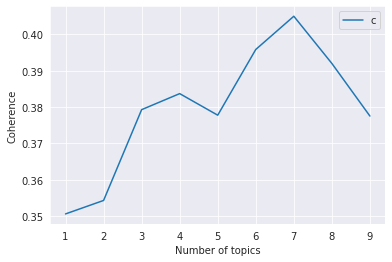

In [ ]:
limit, start, step = 10, 1, 1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
index = coherence_values.index(max(coherence_values))
model_list[index].show_topics()

[(0,
  '0.007*"want" + 0.006*"life" + 0.005*"time" + 0.005*"feel" + 0.005*"happy" + 0.005*"beautiful" + 0.004*"people" + 0.004*"dream" + 0.004*"place" + 0.004*"school"'),
 (1,
  '0.006*"good" + 0.006*"want" + 0.006*"time" + 0.006*"study" + 0.006*"family" + 0.005*"life" + 0.005*"try" + 0.005*"change" + 0.004*"new" + 0.004*"people"'),
 (2,
  '0.026*"time" + 0.015*"change" + 0.008*"people" + 0.008*"life" + 0.007*"study" + 0.005*"want" + 0.005*"happy" + 0.005*"friend" + 0.005*"good" + 0.005*"stop"'),
 (3,
  '0.006*"time" + 0.005*"good" + 0.005*"place" + 0.005*"life" + 0.005*"money" + 0.005*"happy" + 0.004*"friend" + 0.004*"new" + 0.004*"want" + 0.004*"people"'),
 (4,
  '0.011*"time" + 0.007*"want" + 0.006*"change" + 0.006*"life" + 0.005*"smile" + 0.005*"school" + 0.005*"love" + 0.004*"parent" + 0.004*"good" + 0.004*"people"'),
 (5,
  '0.008*"family" + 0.006*"good" + 0.006*"want" + 0.005*"love" + 0.005*"butterfly" + 0.005*"flower" + 0.005*"beautiful" + 0.005*"people" + 0.004*"mother" + 0.00

In [ ]:
import pyLDAvis.gensim_models

lda_display = pyLDAvis.gensim_models.prepare(model_list[index], corpus_tfidf, id2word, sort_topics = False, R = 15)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

